In [157]:
#!/usr/bin/python

# Import required modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from sklearn.svm import SVC
from sklearn.preprocessing import scale

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

# Function Definitions

In [158]:
def tabulate(predicted, true):
    if len(predicted) != len(true):
        print 'Label vectors must be same size!'
        return
    
    names = np.unique(np.concatenate((predicted, true)))
    n_classes = names.size
    m = np.zeros((n_classes, n_classes))
    n = len(predicted)
    
    # TODO: generalize this to more than 2
    # classes of arbitrary labels
    for p, t in zip(predicted, true):
        if p == 'IZA' and t == 'IZA':
            m[0, 0] += 1
        elif p == 'DEEM' and t == 'DEEM':
            m[1, 1] += 1
        elif p == 'IZA' and t == 'DEEM':
            m[1, 0] += 1
        elif p == 'DEEM' and t == 'IZA':
            m[0, 1] += 1
    m /= n
    return n, m

def rand_idxs(n_IZA, n_DEEM, n_train, n_test):
    IZA_idxs = np.arange(0, n_IZA)
    DEEM_idxs = np.arange(0, n_DEEM)

    np.random.shuffle(IZA_idxs)
    np.random.shuffle(DEEM_idxs)

    IZA_train = IZA_idxs[0:n_train]
    IZA_test = IZA_idxs[n_train:n_train+n_test]

    DEEM_train = DEEM_idxs[0:n_train]
    DEEM_test = DEEM_idxs[n_train:n_train+n_test]
    #DEEM_test = DEEM_idxs[n_train:]

    shuffle_train_idxs = np.arange(0, 2*n_train)
    shuffle_test_idxs = np.arange(0, 2*n_test)
    #shuffle_test_idxs = np.arange(0, n_DEEM-n_train+n_test)

    np.random.shuffle(shuffle_train_idxs)
    np.random.shuffle(shuffle_test_idxs)
    
    return IZA_train, IZA_test, \
        DEEM_train, DEEM_test, \
        shuffle_train_idxs, shuffle_test_idxs

def fps_unique(fps_file, prec=12, plot=False):
    idxs, fps_distances = np.loadtxt(fps_file, unpack=True)
    n_nonzero = np.shape(fps_distances[fps_distances.round(prec) > 0])[0]
    
    print 'Unique points with prec = %d: %d' % (prec, n_nonzero)
    
    idxs = idxs[fps_distances.round(prec) > 0].astype(np.int)
    fps_distances = fps_distances[fps_distances.round(prec) > 0]
    
    if plot is True:
        fig = plt.figure(figsize=(3.5, 3.5))
        axs = fig.add_subplot(1, 1, 1)
        axs.semilogy(np.arange(0, fps_distances.shape[0]), fps_distances)
        axs.axvline(n_nonzero, color='r', linestyle='--')
        plt.show()
        
    return idxs#, fps_distances

# PCA Plots

Unique points with prec = 12: 7030
Unique points with prec = 12: 496


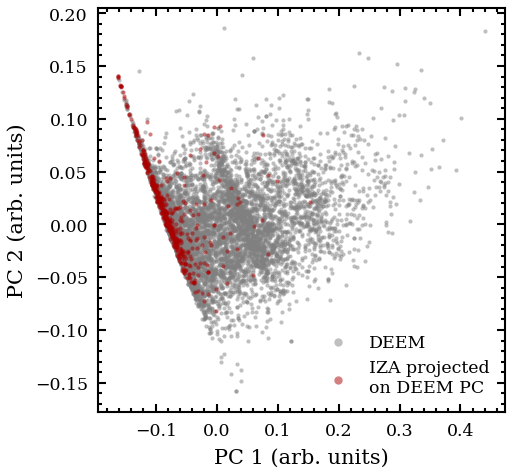

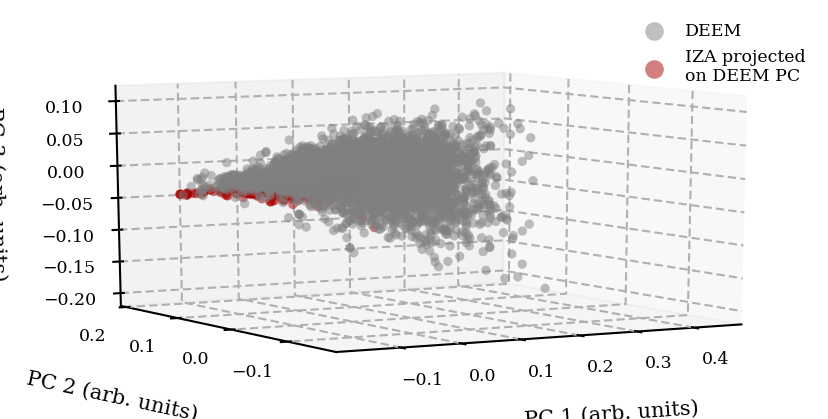

In [159]:
# Load PCA data for IZA and DEEM (3.5 A SOAP cutoff)
udxs_DEEM_PCA_3 = fps_unique('../Processed_Data/DEEM_1k/PCA/3.5/FPS-uPCA.idxs')
udxs_IZA_PCA_3 = fps_unique('../Processed_Data/IZAonDEEM_1k/PCA/3.5/FPS-uPCA.idxs')
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/3.5/pca-0.npy')[udxs_DEEM_PCA_3, :]
pcaIZA = np.load('../Processed_Data/IZAonDEEM_1k/PCA/3.5/pca-0.npy')[udxs_IZA_PCA_3, :]

### 2D PCA ###

# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot of IZA and DEEM
scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and tick sizes
axsScat.set_xlabel('PC 1 (arb. units)')
axsScat.set_ylabel('PC 2 (arb. units)')

# Figure legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

# Save figure
figPCA.savefig('../Results/DEEM_1k/pca_IZAonDEEM_3.5.png', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], pcaIZA[:, 1], pcaIZA[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

axs3D.set_xlabel('PC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('PC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('PC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
axs3D.view_init(10, -120)

axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)#, fontsize=24)

fig3D.savefig('../Results/DEEM_1k/pca_IZAonDEEM_3.5_3D.png', bbox_inches='tight')

plt.show()

Unique points with prec = 12: 7324
Unique points with prec = 12: 530


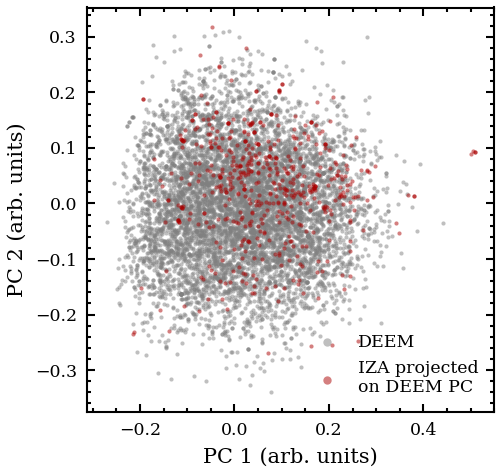

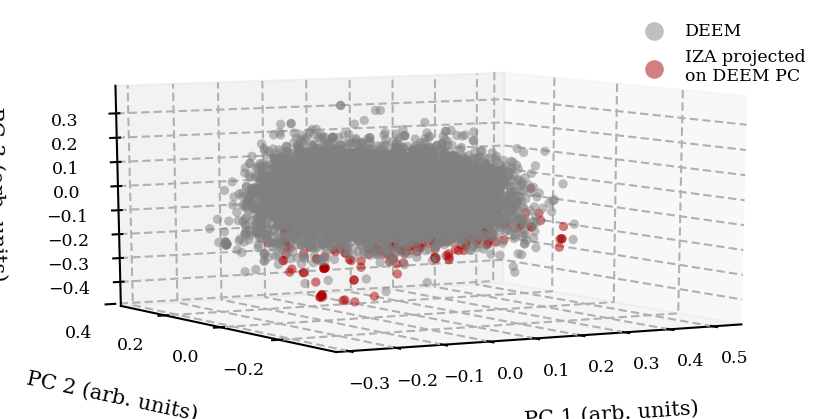

In [160]:
# Load PCA data for IZA and DEEM (6.0 A SOAP cutoff)
udxs_DEEM_PCA_6 = fps_unique('../Processed_Data/DEEM_1k/PCA/6.0/FPS-uPCA.idxs')
udxs_IZA_PCA_6 = fps_unique('../Processed_Data/IZAonDEEM_1k/PCA/6.0/FPS-uPCA.idxs')
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/6.0/pca-0.npy')[udxs_DEEM_PCA_6, :]
pcaIZA = np.load('../Processed_Data/IZAonDEEM_1k/PCA/6.0/pca-0.npy')[udxs_IZA_PCA_6, :]

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

axsScat.set_xlabel('PC 1 (arb. units)')
axsScat.set_ylabel('PC 2 (arb. units)')


axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

figPCA.savefig('../Results/DEEM_1k/pca_IZAonDEEM_6.0.png', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], pcaIZA[:, 1], pcaIZA[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

axs3D.set_xlabel('PC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('PC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('PC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

fig3D.savefig('../Results/DEEM_1k/pca_IZAonDEEM_6.0_3D.png', bbox_inches='tight')

plt.show()

# KPCA Plots

Unique points with prec = 12: 7035
Unique points with prec = 12: 496


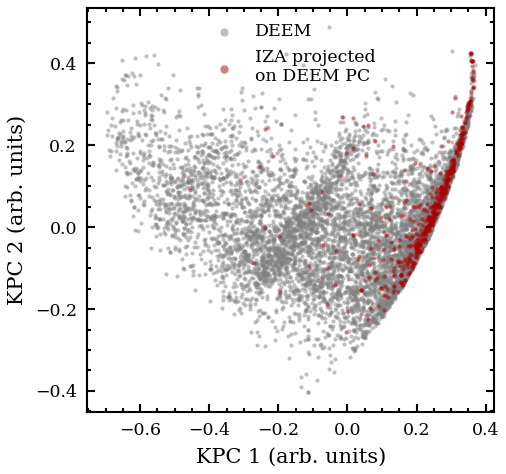

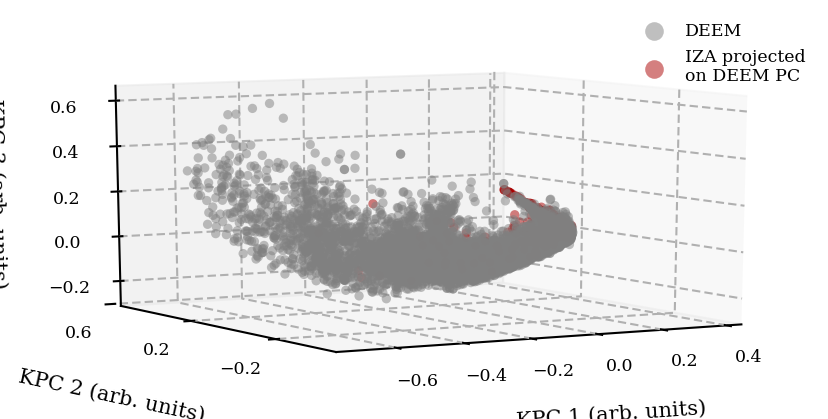

In [161]:
# Load PCA data for IZA and DEEM (3.5 A SOAP cutoff)
udxs_DEEM_KPCA_3 = fps_unique('../Processed_Data/DEEM_1k/PCA/3.5/FPS-uKPCA.idxs')
udxs_IZA_KPCA_3 = fps_unique('../Processed_Data/IZAonDEEM_1k/PCA/3.5/FPS-uKPCA.idxs')
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')[udxs_DEEM_KPCA_3, :]
pcaIZA = np.load('../Processed_Data/IZAonDEEM_1k/PCA/3.5/kpca_proj.npy')[udxs_IZA_KPCA_3, :]

### 2D PCA ###

# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot of IZA and DEEM
scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and tick sizes
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Figure legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

# Save figure
figPCA.savefig('../Results/DEEM_1k/kpca_IZAonDEEM_3.5.png', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], pcaIZA[:, 1], pcaIZA[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
axs3D.view_init(10, -120)

axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)#, fontsize=24)

fig3D.savefig('../Results/DEEM_1k/kpca_IZAonDEEM_3.5_3D.png', bbox_inches='tight')

plt.show()

Unique points with prec = 12: 7321
Unique points with prec = 12: 530


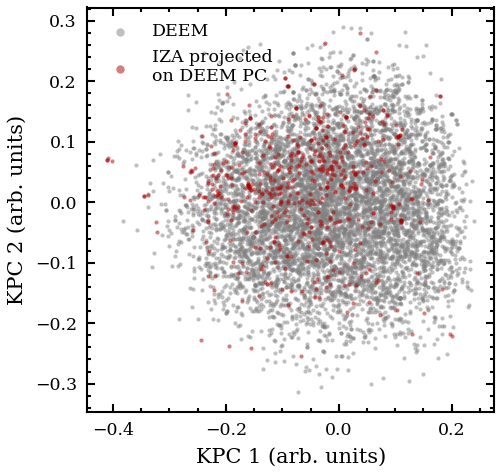

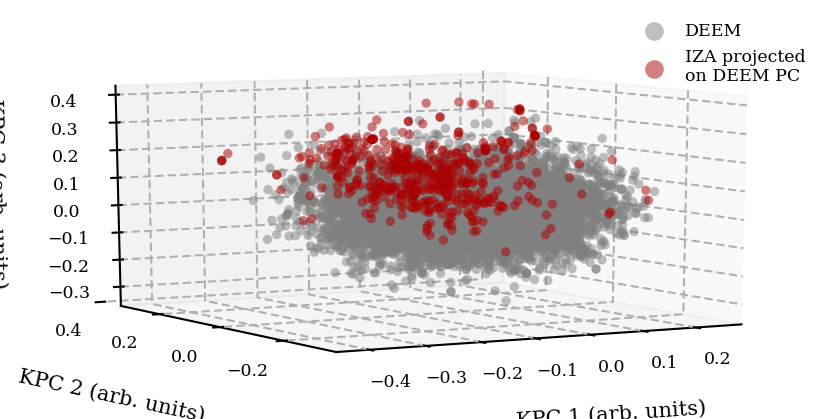

In [162]:
# Load PCA data for IZA and DEEM (6.0 A SOAP cutoff)
udxs_DEEM_KPCA_6 = fps_unique('../Processed_Data/DEEM_1k/PCA/6.0/FPS-uKPCA.idxs')
udxs_IZA_KPCA_6 = fps_unique('../Processed_Data/IZAonDEEM_1k/PCA/6.0/FPS-uKPCA.idxs')
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')[udxs_DEEM_KPCA_6, :]
pcaIZA = np.load('../Processed_Data/IZAonDEEM_1k/PCA/6.0/kpca_proj.npy')[udxs_IZA_KPCA_6, :]

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')


axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

figPCA.savefig('../Results/DEEM_1k/kpca_IZAonDEEM_6.0.png', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], pcaIZA[:, 1], pcaIZA[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

fig3D.savefig('../Results/DEEM_1k/kpca_IZAonDEEM_6.0_3D.png', bbox_inches='tight')

plt.show()

# Environment Properties

In [163]:
DEEM_E_3 = np.loadtxt('../Processed_Data/DEEM_1k/Energy/3.5/Gaussian/envProperties-0.dat')
DEEM_V_3 = np.loadtxt('../Processed_Data/DEEM_1k/Volume/3.5/Gaussian/envProperties-0.dat')
IZA_E_3 = np.loadtxt('../Processed_Data/IZAonDEEM_1k/Energy/3.5/Gaussian/envProperties_proj-0.dat')
IZA_V_3 = np.loadtxt('../Processed_Data/IZAonDEEM_1k/Volume/3.5/Gaussian/envProperties_proj-0.dat')

DEEM_E_6 = np.loadtxt('../Processed_Data/DEEM_1k/Energy/6.0/Gaussian/envProperties-0.dat')
DEEM_V_6 = np.loadtxt('../Processed_Data/DEEM_1k/Volume/6.0/Gaussian/envProperties-0.dat')
IZA_E_6 = np.loadtxt('../Processed_Data/IZAonDEEM_1k/Energy/6.0/Gaussian/envProperties_proj-0.dat')
IZA_V_6 = np.loadtxt('../Processed_Data/IZAonDEEM_1k/Volume/6.0/Gaussian/envProperties_proj-0.dat')

DEEM_atoms = np.loadtxt('../Processed_Data/DEEM_1k/atoms.dat', usecols=(7, 8, 9))
IZA_atoms = np.loadtxt('../Processed_Data/IZA/atoms.dat', usecols=(7, 8))

In [164]:
IZA_u, IZA_idxs = np.unique(IZA_atoms[:, 0], return_index=True)
DEEM_u, DEEM_idxs = np.unique(DEEM_atoms[:, 0], return_index=True)

IZA_V = IZA_atoms[IZA_idxs, 1]
DEEM_V = DEEM_atoms[DEEM_idxs, 1]
DEEM_E = DEEM_atoms[DEEM_idxs, 2]

IZA_V_3_sum = np.zeros(IZA_u.size)
IZA_V_6_sum = np.zeros(IZA_u.size)

DEEM_V_3_sum = np.zeros(DEEM_u.size)
DEEM_V_6_sum = np.zeros(DEEM_u.size)

DEEM_E_3_sum = np.zeros(DEEM_u.size)
DEEM_E_6_sum = np.zeros(DEEM_u.size)

DEEM_n_atoms = np.zeros(DEEM_u.size) # Number of Si atoms
DEEM_n_atoms[0:-1] = np.diff(DEEM_idxs)
DEEM_n_atoms[-1] = DEEM_atoms.shape[0] - DEEM_idxs[-1]
DEEM_E_avg = DEEM_E*DEEM_n_atoms - np.mean(DEEM_E*DEEM_n_atoms)

for i in IZA_u.astype(np.int):
    idxs = IZA_atoms[:, 0] == i
    IZA_V_3_sum[i] = (IZA_V[i] - np.sum(IZA_V_3[idxs]))/IZA_V[i]
    IZA_V_6_sum[i] = (IZA_V[i] - np.sum(IZA_V_6[idxs]))/IZA_V[i]
    
for i in DEEM_u.astype(np.int):
    idxs = DEEM_atoms[:, 0] == i
    
    DEEM_V_3_sum[i] = (DEEM_V[i] - np.sum(DEEM_V_3[idxs]))/DEEM_V[i]
    DEEM_V_6_sum[i] = (DEEM_V[i] - np.sum(DEEM_V_6[idxs]))/DEEM_V[i]
    
    DEEM_E_3_sum[i] = (DEEM_E_avg[i] - np.sum(DEEM_E_3[idxs]))/DEEM_E_avg[i]
    DEEM_E_6_sum[i] = (DEEM_E_avg[i] - np.sum(DEEM_E_6[idxs]))/DEEM_E_avg[i]

print "IZA V 3.5: ", np.mean(np.abs(IZA_V_3_sum))*100, np.mean(np.abs(IZA_V_3_sum*IZA_V))
print "IZA V 6.0: ", np.mean(np.abs(IZA_V_6_sum))*100, np.mean(np.abs(IZA_V_6_sum*IZA_V))

print "DEEM V 3.5: ", np.mean(np.abs(DEEM_V_3_sum))*100, np.mean(np.abs(DEEM_V_3_sum*DEEM_V))
print "DEEM V 6.0: ", np.mean(np.abs(DEEM_V_6_sum))*100, np.mean(np.abs(DEEM_V_6_sum*DEEM_V))

print "DEEM E 3.5: ", np.mean(np.abs(DEEM_E_3_sum))*100, np.mean(np.abs(DEEM_E_3_sum*DEEM_E_avg))
print "DEEM E 6.0: ", np.mean(np.abs(DEEM_E_6_sum))*100, np.mean(np.abs(DEEM_E_6_sum*DEEM_E_avg))

IZA V 3.5:  28.390364011245094 1367.89231485833
IZA V 6.0:  2.8806883085630726 139.51731968554301
DEEM V 3.5:  4.350704255756063 130.0925149019119
DEEM V 6.0:  1.8101296437672256 58.68443763438869
DEEM E 3.5:  99.98142252917239 287838.6135749626
DEEM E 6.0:  99.98245233891807 287841.59205003566


# SVM Classification

## 3.5

In [165]:
f_train = 0.8

udxs_IZA_SOAP_3 = fps_unique('../Processed_Data/IZAonDEEM_1k/PCA/3.5/FPS-uSOAP.idxs')
udxs_DEEM_SOAP_3 = fps_unique('../Processed_Data/DEEM_1k/PCA/3.5/FPS-uSOAP.idxs')

n_IZA_SOAP = udxs_IZA_SOAP_3.size
n_DEEM_SOAP = udxs_DEEM_SOAP_3.size
n_train_SOAP = int(f_train*n_IZA_SOAP)
n_test_SOAP = n_IZA_SOAP - n_train_SOAP

print n_IZA_SOAP
print n_DEEM_SOAP
print n_train_SOAP
print n_test_SOAP

n_IZA_PCA = udxs_IZA_PCA_3.size
n_DEEM_PCA = udxs_DEEM_PCA_3.size
n_train_PCA = int(f_train*n_IZA_PCA)
n_test_PCA = n_IZA_PCA - n_train_PCA

print n_IZA_PCA
print n_DEEM_PCA
print n_train_PCA
print n_test_PCA

n_IZA_KPCA = udxs_IZA_KPCA_3.size
n_DEEM_KPCA = udxs_DEEM_KPCA_3.size
n_train_KPCA = int(f_train*n_IZA_KPCA)
n_test_KPCA = n_IZA_KPCA - n_train_KPCA

print n_IZA_KPCA
print n_DEEM_KPCA
print n_train_KPCA
print n_test_KPCA

Unique points with prec = 12: 496
Unique points with prec = 12: 7030
496
7030
396
100
496
7030
396
100
496
7035
396
100


In [166]:
#IZA_SOAP = np.load('../Processed_Data/IZA/PCA/3.5/SOAPs-0.npy')
IZA_SOAP = np.load('../Processed_Data/IZAonDEEM_1k/PCA/3.5/SOAPs-0.npy')[udxs_IZA_SOAP_3, :]
DEEM_SOAP = np.load('../Processed_Data/DEEM_1k/PCA/3.5/SOAPs-0.npy')[udxs_DEEM_SOAP_3, :]

IZA_PCA = np.load('../Processed_Data/IZAonDEEM_1k/PCA/3.5/pca-0.npy')[udxs_IZA_PCA_3, :]
DEEM_PCA = np.load('../Processed_Data/DEEM_1k/PCA/3.5/pca-0.npy')[udxs_DEEM_PCA_3]

IZA_KPCA = np.load('../Processed_Data/IZAonDEEM_1k/PCA/3.5/kpca_proj.npy')[udxs_IZA_KPCA_3, :]
DEEM_KPCA = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')[udxs_DEEM_KPCA_3, :]

# Indices
IZA_train_SOAP, IZA_test_SOAP, \
        DEEM_train_SOAP, DEEM_test_SOAP, \
        shuffle_train_idxs_SOAP, shuffle_test_idxs_SOAP = rand_idxs(n_IZA_SOAP, n_DEEM_SOAP, 
                                                                    n_train_SOAP, n_test_SOAP)
IZA_train_PCA, IZA_test_PCA, \
        DEEM_train_PCA, DEEM_test_PCA, \
        shuffle_train_idxs_PCA, shuffle_test_idxs_PCA = rand_idxs(n_IZA_PCA, n_DEEM_PCA, 
                                                                    n_train_PCA, n_test_PCA)
IZA_train_KPCA, IZA_test_KPCA, \
        DEEM_train_KPCA, DEEM_test_KPCA, \
        shuffle_train_idxs_KPCA, shuffle_test_idxs_KPCA = rand_idxs(n_IZA_KPCA, n_DEEM_KPCA, 
                                                                    n_train_KPCA, n_test_KPCA)

# Scaling
SOAP_train = np.concatenate((IZA_SOAP[IZA_train_SOAP], DEEM_SOAP[DEEM_train_SOAP]))[shuffle_train_idxs_SOAP]
SOAP_test = np.concatenate((IZA_SOAP[IZA_test_SOAP], DEEM_SOAP[DEEM_test_SOAP]))[shuffle_test_idxs_SOAP]
u_SOAP = np.mean(np.concatenate((SOAP_train, SOAP_test)), axis=0)
s_SOAP = np.std(np.concatenate((SOAP_train, SOAP_test)), axis=0)
SOAP_train = (SOAP_train - u_SOAP)/s_SOAP
SOAP_test = (SOAP_test - u_SOAP)/s_SOAP
train_labels_SOAP = np.asarray(['IZA']*n_train_SOAP + ['DEEM']*n_train_SOAP)[shuffle_train_idxs_SOAP]
test_labels_SOAP = np.asarray(['IZA']*n_test_SOAP + ['DEEM']*n_test_SOAP)[shuffle_test_idxs_SOAP]

PCA_train = np.concatenate((IZA_PCA[IZA_train_PCA], DEEM_PCA[DEEM_train_PCA]))[shuffle_train_idxs_PCA]
PCA_test = np.concatenate((IZA_PCA[IZA_test_PCA], DEEM_PCA[DEEM_test_PCA]))[shuffle_test_idxs_PCA]
u_PCA = np.mean(np.concatenate((PCA_train, PCA_test)), axis=0)
s_PCA = np.std(np.concatenate((PCA_train, PCA_test)), axis=0)
PCA_train = (PCA_train - u_PCA)/s_PCA
PCA_test = (PCA_test - u_PCA)/s_PCA
train_labels_PCA = np.asarray(['IZA']*n_train_PCA + ['DEEM']*n_train_PCA)[shuffle_train_idxs_PCA]
test_labels_PCA = np.asarray(['IZA']*n_test_PCA + ['DEEM']*n_test_PCA)[shuffle_test_idxs_PCA]

KPCA_train = np.concatenate((IZA_KPCA[IZA_train_KPCA], DEEM_KPCA[DEEM_train_KPCA]))[shuffle_train_idxs_KPCA]
KPCA_test = np.concatenate((IZA_KPCA[IZA_test_KPCA], DEEM_KPCA[DEEM_test_KPCA]))[shuffle_test_idxs_KPCA]
u_KPCA = np.mean(np.concatenate((KPCA_train, KPCA_test)), axis=0)
s_KPCA = np.std(np.concatenate((KPCA_train, KPCA_test)), axis=0)
KPCA_train = (KPCA_train - u_KPCA)/s_KPCA
KPCA_test = (KPCA_test - u_KPCA)/s_KPCA
train_labels_KPCA = np.asarray(['IZA']*n_train_KPCA + ['DEEM']*n_train_KPCA)[shuffle_train_idxs_KPCA]
test_labels_KPCA = np.asarray(['IZA']*n_test_KPCA + ['DEEM']*n_test_KPCA)[shuffle_test_idxs_KPCA]

#test_labels = np.asarray(['IZA']*n_test + ['DEEM']*(n_DEEM-n_train))[shuffle_test_idxs]

In [169]:
# Train SVC

# SOAP
svc_SOAP = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_SOAP.fit(SOAP_train, train_labels_SOAP)
SOAP_score = svc_SOAP.score(SOAP_test, test_labels_SOAP)
SOAP_labels = svc_SOAP.predict(SOAP_test)
n_samples, m_SOAP = tabulate(SOAP_labels, test_labels_SOAP)
print "SOAP: ", SOAP_score
print m_SOAP

# PCA
n_PCA = 2
svc_PCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_PCA.fit(PCA_train[:, 0:n_PCA], train_labels_PCA)
PCA_score = svc_PCA.score(PCA_test[:, 0:n_PCA], test_labels_PCA)
PCA_labels = svc_PCA.predict(PCA_test[:, 0:n_PCA])
n_samples, m_PCA = tabulate(PCA_labels, test_labels_PCA)
print "PCA: ", PCA_score
print m_PCA

# KPCA
n_KPCA = 2
svc_KPCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_KPCA.fit(KPCA_train[:, 0:n_KPCA], train_labels_KPCA)
KPCA_score = svc_KPCA.score(KPCA_test[:, 0:n_KPCA], test_labels_KPCA)
KPCA_labels = svc_KPCA.predict(KPCA_test[:, 0:n_KPCA])
n_samples, m_KPCA = tabulate(KPCA_labels, test_labels_KPCA)
print "KPCA: ", KPCA_score
print m_PCA

SOAP:  0.97
[[0.485 0.015]
 [0.015 0.485]]
PCA:  0.7
[[0.41 0.09]
 [0.21 0.29]]
KPCA:  0.71
[[0.41 0.09]
 [0.21 0.29]]


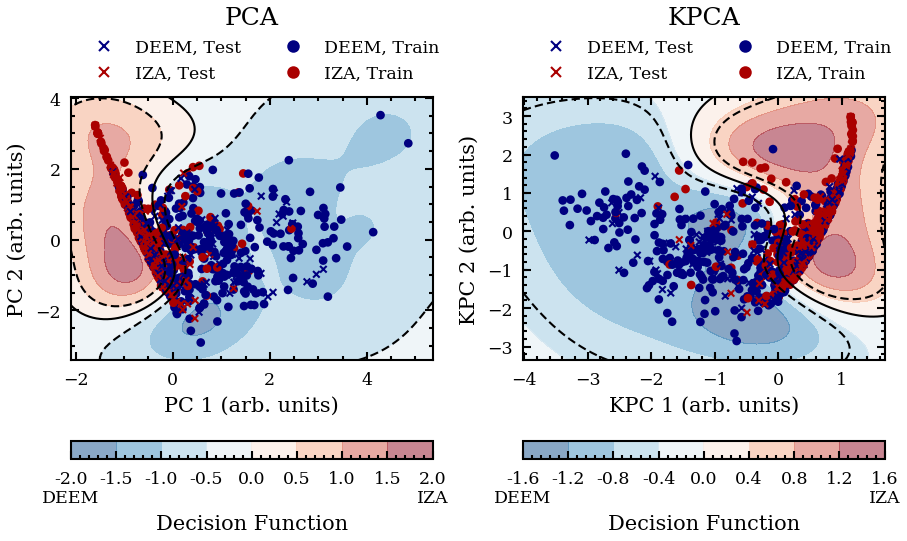

In [170]:
fig = plt.figure(figsize=(7.0, 3.5))
axs_PCA = fig.add_subplot(1, 2, 1)
axs_KPCA = fig.add_subplot(1, 2, 2)

colors_train_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_PCA]
colors_test_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_PCA]

colors_train_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_KPCA]
colors_test_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_KPCA]

PCA_min_x = np.amin(np.concatenate((PCA_train, PCA_test))[:, 0])
PCA_min_y = np.amin(np.concatenate((PCA_train, PCA_test))[:, 1])
PCA_max_x = np.amax(np.concatenate((PCA_train, PCA_test))[:, 0])
PCA_max_y = np.amax(np.concatenate((PCA_train, PCA_test))[:, 1])

PCA_xx, PCA_yy = np.meshgrid(np.linspace(PCA_min_x-0.5, PCA_max_x+0.5, 100),
                             np.linspace(PCA_min_y-0.5, PCA_max_y+0.5, 100))

df_PCA = svc_PCA.decision_function(np.column_stack((PCA_xx.ravel(), PCA_yy.ravel())))
df_PCA = np.reshape(df_PCA, PCA_xx.shape)

KPCA_min_x = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 0])
KPCA_min_y = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 1])
KPCA_max_x = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 0])
KPCA_max_y = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 1])

KPCA_xx, KPCA_yy = np.meshgrid(np.linspace(KPCA_min_x-0.5, KPCA_max_x+0.5, 100),
                               np.linspace(KPCA_min_y-0.5, KPCA_max_y+0.5, 100))

df_KPCA = svc_KPCA.decision_function(np.column_stack((KPCA_xx.ravel(), KPCA_yy.ravel())))
df_KPCA = np.reshape(df_KPCA, KPCA_xx.shape)

contour_PCA = axs_PCA.contourf(PCA_xx, PCA_yy, df_PCA, cmap='RdBu_r', alpha=0.5)
axs_PCA.contour(PCA_xx, PCA_yy, df_PCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_PCA.scatter(PCA_train[:, 0], PCA_train[:, 1], marker='o', c=colors_train_PCA[:], s=10)
axs_PCA.scatter(PCA_test[:, 0], PCA_test[:, 1], marker='x', c=colors_test_PCA[:], s=10)

contour_KPCA = axs_KPCA.contourf(KPCA_xx, KPCA_yy, df_KPCA, cmap='RdBu_r', alpha=0.5)
axs_KPCA.contour(KPCA_xx, KPCA_yy, df_KPCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_KPCA.scatter(KPCA_train[:, 0], KPCA_train[:, 1], marker='o', c=colors_train_KPCA[:], s=10)
axs_KPCA.scatter(KPCA_test[:, 0], KPCA_test[:, 1], marker='x', c=colors_test_KPCA[:], s=10)

axs_PCA.set_xlabel('PC 1 (arb. units)')
axs_PCA.set_ylabel('PC 2 (arb. units)')

axs_KPCA.set_xlabel('KPC 1 (arb. units)')
axs_KPCA.set_ylabel('KPC 2 (arb. units)')

xblue = mpllines.Line2D([], [], color=colorList[2], marker='x', 
                        markersize=5, linestyle='None', label='DEEM, Test')
oblue = mpllines.Line2D([], [], color=colorList[2], marker='o', 
                        markersize=5, linestyle='None', label='DEEM, Train')
xred = mpllines.Line2D([], [], color=colorList[1], marker='x',
                      markersize=5, linestyle='None', label='IZA, Test')
ored = mpllines.Line2D([], [], color=colorList[1], marker='o',
                      markersize=5, linestyle='None', label='IZA, Train')

axs_PCA.legend(handles=(xblue, xred, oblue, ored), loc='lower left', 
               bbox_to_anchor=(0.0, 1.0), ncol=2)
axs_KPCA.legend(handles=(xblue, xred, oblue, ored), loc='lower left', 
               bbox_to_anchor=(0.0, 1.0), ncol=2)

axs_PCA.set_title('PCA', pad=35)
axs_KPCA.set_title('KPCA', pad=35)

cb_PCA = fig.colorbar(contour_PCA, ax=axs_PCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')
cb_KPCA = fig.colorbar(contour_KPCA, ax=axs_KPCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')

cb_PCA_ticks = ['%.1f' % i for i in cb_PCA.get_ticks()]
cb_PCA_ticks[0] = cb_PCA_ticks[0] + '\nDEEM'
cb_PCA_ticks[-1] = cb_PCA_ticks[-1] + '\nIZA'
cb_PCA.set_ticklabels(cb_PCA_ticks)

cb_KPCA_ticks = ['%.1f' % i for i in cb_KPCA.get_ticks()]
cb_KPCA_ticks[0] = cb_KPCA_ticks[0] + '\nDEEM'
cb_KPCA_ticks[-1] = cb_KPCA_ticks[-1] + '\nIZA'
cb_KPCA.set_ticklabels(cb_KPCA_ticks)

fig.subplots_adjust(wspace=0.25)

fig.savefig('../Results/DEEM_1k/svm_IZAonDEEM_3.5.png', bbox_inches='tight')

plt.show()

## 6.0

In [171]:
f_train = 0.8

udxs_IZA_SOAP_6 = fps_unique('../Processed_Data/IZAonDEEM_1k/PCA/6.0/FPS-uSOAP.idxs')
udxs_DEEM_SOAP_6 = fps_unique('../Processed_Data/DEEM_1k/PCA/6.0/FPS-uSOAP.idxs')

n_IZA_SOAP = udxs_IZA_SOAP_6.size
n_DEEM_SOAP = udxs_DEEM_SOAP_6.size
n_train_SOAP = int(f_train*n_IZA_SOAP)
n_test_SOAP = n_IZA_SOAP - n_train_SOAP

print n_IZA_SOAP
print n_DEEM_SOAP
print n_train_SOAP
print n_test_SOAP

n_IZA_PCA = udxs_IZA_PCA_6.size
n_DEEM_PCA = udxs_DEEM_PCA_6.size
n_train_PCA = int(f_train*n_IZA_PCA)
n_test_PCA = n_IZA_PCA - n_train_PCA

print n_IZA_PCA
print n_DEEM_PCA
print n_train_PCA
print n_test_PCA

n_IZA_KPCA = udxs_IZA_KPCA_6.size
n_DEEM_KPCA = udxs_DEEM_KPCA_6.size
n_train_KPCA = int(f_train*n_IZA_KPCA)
n_test_KPCA = n_IZA_KPCA - n_train_KPCA

print n_IZA_KPCA
print n_DEEM_KPCA
print n_train_KPCA
print n_test_KPCA

Unique points with prec = 12: 530
Unique points with prec = 12: 7325
530
7325
424
106
530
7324
424
106
530
7321
424
106


In [172]:
#IZA_SOAP = np.load('../Processed_Data/IZA/PCA/6.0/SOAPs-0.npy')
IZA_SOAP = np.load('../Processed_Data/IZAonDEEM_1k/PCA/6.0/SOAPs-0.npy')[udxs_IZA_SOAP_6, :]
DEEM_SOAP = np.load('../Processed_Data/DEEM_1k/PCA/6.0/SOAPs-0.npy')[udxs_DEEM_SOAP_6, :]

IZA_PCA = np.load('../Processed_Data/IZAonDEEM_1k/PCA/6.0/pca-0.npy')[udxs_IZA_PCA_6, :]
DEEM_PCA = np.load('../Processed_Data/DEEM_1k/PCA/6.0/pca-0.npy')[udxs_DEEM_PCA_6, :]

IZA_KPCA = np.load('../Processed_Data/IZAonDEEM_1k/PCA/6.0/kpca_proj.npy')[udxs_IZA_KPCA_6, :]
DEEM_KPCA = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')[udxs_DEEM_KPCA_6, :]

# Indices
IZA_train_SOAP, IZA_test_SOAP, \
        DEEM_train_SOAP, DEEM_test_SOAP, \
        shuffle_train_idxs_SOAP, shuffle_test_idxs_SOAP = rand_idxs(n_IZA_SOAP, n_DEEM_SOAP, 
                                                                    n_train_SOAP, n_test_SOAP)
IZA_train_PCA, IZA_test_PCA, \
        DEEM_train_PCA, DEEM_test_PCA, \
        shuffle_train_idxs_PCA, shuffle_test_idxs_PCA = rand_idxs(n_IZA_PCA, n_DEEM_PCA, 
                                                                    n_train_PCA, n_test_PCA)
IZA_train_KPCA, IZA_test_KPCA, \
        DEEM_train_KPCA, DEEM_test_KPCA, \
        shuffle_train_idxs_KPCA, shuffle_test_idxs_KPCA = rand_idxs(n_IZA_KPCA, n_DEEM_KPCA, 
                                                                    n_train_KPCA, n_test_KPCA)
    
# Scaling
SOAP_train = np.concatenate((IZA_SOAP[IZA_train_SOAP], DEEM_SOAP[DEEM_train_SOAP]))[shuffle_train_idxs_SOAP]
SOAP_test = np.concatenate((IZA_SOAP[IZA_test_SOAP], DEEM_SOAP[DEEM_test_SOAP]))[shuffle_test_idxs_SOAP]
u_SOAP = np.mean(np.concatenate((SOAP_train, SOAP_test)), axis=0)
s_SOAP = np.std(np.concatenate((SOAP_train, SOAP_test)), axis=0)
SOAP_train = (SOAP_train - u_SOAP)/s_SOAP
SOAP_test = (SOAP_test - u_SOAP)/s_SOAP
train_labels_SOAP = np.asarray(['IZA']*n_train_SOAP + ['DEEM']*n_train_SOAP)[shuffle_train_idxs_SOAP]
test_labels_SOAP = np.asarray(['IZA']*n_test_SOAP + ['DEEM']*n_test_SOAP)[shuffle_test_idxs_SOAP]

PCA_train = np.concatenate((IZA_PCA[IZA_train_PCA], DEEM_PCA[DEEM_train_PCA]))[shuffle_train_idxs_PCA]
PCA_test = np.concatenate((IZA_PCA[IZA_test_PCA], DEEM_PCA[DEEM_test_PCA]))[shuffle_test_idxs_PCA]
u_PCA = np.mean(np.concatenate((PCA_train, PCA_test)), axis=0)
s_PCA = np.std(np.concatenate((PCA_train, PCA_test)), axis=0)
PCA_train = (PCA_train - u_PCA)/s_PCA
PCA_test = (PCA_test - u_PCA)/s_PCA
train_labels_PCA = np.asarray(['IZA']*n_train_PCA + ['DEEM']*n_train_PCA)[shuffle_train_idxs_PCA]
test_labels_PCA = np.asarray(['IZA']*n_test_PCA + ['DEEM']*n_test_PCA)[shuffle_test_idxs_PCA]

KPCA_train = np.concatenate((IZA_KPCA[IZA_train_KPCA], DEEM_KPCA[DEEM_train_KPCA]))[shuffle_train_idxs_KPCA]
KPCA_test = np.concatenate((IZA_KPCA[IZA_test_KPCA], DEEM_KPCA[DEEM_test_KPCA]))[shuffle_test_idxs_KPCA]
u_KPCA = np.mean(np.concatenate((KPCA_train, KPCA_test)), axis=0)
s_KPCA = np.std(np.concatenate((KPCA_train, KPCA_test)), axis=0)
KPCA_train = (KPCA_train - u_KPCA)/s_KPCA
KPCA_test = (KPCA_test - u_KPCA)/s_KPCA
train_labels_KPCA = np.asarray(['IZA']*n_train_KPCA + ['DEEM']*n_train_KPCA)[shuffle_train_idxs_KPCA]
test_labels_KPCA = np.asarray(['IZA']*n_test_KPCA + ['DEEM']*n_test_KPCA)[shuffle_test_idxs_KPCA]

#test_labels = np.asarray(['IZA']*n_test + ['DEEM']*(n_DEEM-n_train))[shuffle_test_idxs]

In [175]:
# Train SVC

# SOAP
svc_SOAP = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_SOAP.fit(SOAP_train, train_labels_SOAP)
SOAP_score = svc_SOAP.score(SOAP_test, test_labels_SOAP)
SOAP_labels = svc_SOAP.predict(SOAP_test)
n_samples, m_SOAP = tabulate(SOAP_labels, test_labels_SOAP)
print "SOAP: ", SOAP_score
print m_SOAP

# PCA
n_PCA = 2
svc_PCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_PCA.fit(PCA_train[:, 0:n_PCA], train_labels_PCA)
PCA_score = svc_PCA.score(PCA_test[:, 0:n_PCA], test_labels_PCA)
PCA_labels = svc_PCA.predict(PCA_test[:, 0:n_PCA])
n_samples, m_PCA = tabulate(PCA_labels, test_labels_PCA)
print "PCA: ", PCA_score
print m_PCA

# KPCA
n_KPCA = 2
svc_KPCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_KPCA.fit(KPCA_train[:, 0:n_KPCA], train_labels_KPCA)
KPCA_score = svc_KPCA.score(KPCA_test[:, 0:n_KPCA], test_labels_KPCA)
KPCA_labels = svc_KPCA.predict(KPCA_test[:, 0:n_KPCA])
n_samples, m_KPCA = tabulate(KPCA_labels, test_labels_KPCA)
print "KPCA: ", KPCA_score
print m_KPCA

SOAP:  0.9528301886792453
[[0.49056604 0.00943396]
 [0.03773585 0.46226415]]
PCA:  0.7216981132075472
[[0.38207547 0.11792453]
 [0.16037736 0.33962264]]
KPCA:  0.6273584905660378
[[0.33962264 0.16037736]
 [0.21226415 0.28773585]]


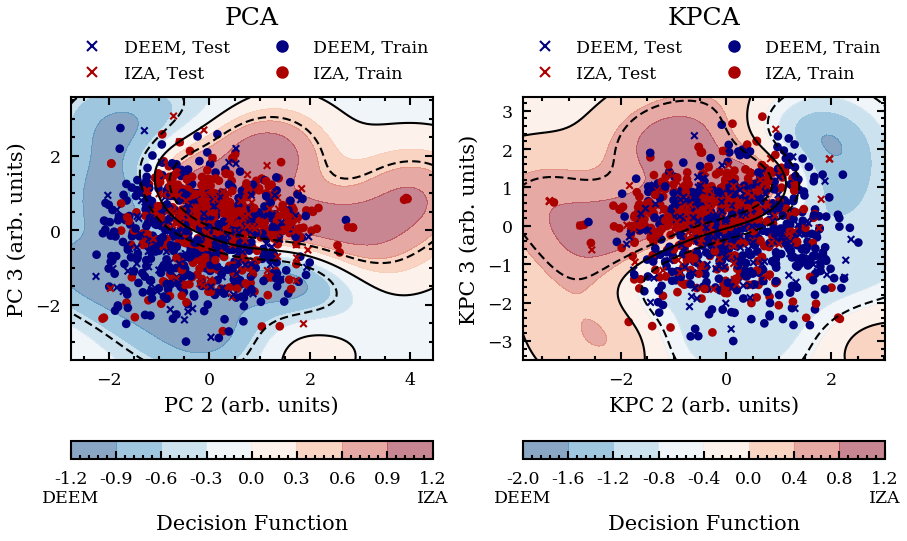

In [176]:
fig = plt.figure(figsize=(7.0, 3.5))
axs_PCA = fig.add_subplot(1, 2, 1)
axs_KPCA = fig.add_subplot(1, 2, 2)

colors_train_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_PCA]
colors_test_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_PCA]

colors_train_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_KPCA]
colors_test_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_KPCA]

PCA_min_x = np.amin(np.concatenate((PCA_train, PCA_test))[:, 0])
PCA_min_y = np.amin(np.concatenate((PCA_train, PCA_test))[:, 1])
PCA_max_x = np.amax(np.concatenate((PCA_train, PCA_test))[:, 0])
PCA_max_y = np.amax(np.concatenate((PCA_train, PCA_test))[:, 1])

PCA_xx, PCA_yy = np.meshgrid(np.linspace(PCA_min_x-0.5, PCA_max_x+0.5, 100),
                             np.linspace(PCA_min_y-0.5, PCA_max_y+0.5, 100))

df_PCA = svc_PCA.decision_function(np.column_stack((PCA_xx.ravel(), PCA_yy.ravel())))
df_PCA = np.reshape(df_PCA, PCA_xx.shape)

KPCA_min_x = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 0])
KPCA_min_y = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 1])
KPCA_max_x = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 0])
KPCA_max_y = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 1])

KPCA_xx, KPCA_yy = np.meshgrid(np.linspace(KPCA_min_x-0.5, KPCA_max_x+0.5, 100),
                               np.linspace(KPCA_min_y-0.5, KPCA_max_y+0.5, 100))

df_KPCA = svc_KPCA.decision_function(np.column_stack((KPCA_xx.ravel(), KPCA_yy.ravel())))
df_KPCA = np.reshape(df_KPCA, KPCA_xx.shape)

contour_PCA = axs_PCA.contourf(PCA_xx, PCA_yy, df_PCA, cmap='RdBu_r', alpha=0.5)
axs_PCA.contour(PCA_xx, PCA_yy, df_PCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_PCA.scatter(PCA_train[:, 0], PCA_train[:, 1], marker='o', c=colors_train_PCA[:], s=10)
axs_PCA.scatter(PCA_test[:, 0], PCA_test[:, 1], marker='x', c=colors_test_PCA[:], s=10)

contour_KPCA = axs_KPCA.contourf(KPCA_xx, KPCA_yy, df_KPCA, cmap='RdBu_r', alpha=0.5)
axs_KPCA.contour(KPCA_xx, KPCA_yy, df_KPCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_KPCA.scatter(KPCA_train[:, 0], KPCA_train[:, 1], marker='o', c=colors_train_KPCA[:], s=10)
axs_KPCA.scatter(KPCA_test[:, 0], KPCA_test[:, 1], marker='x', c=colors_test_KPCA[:], s=10)

axs_PCA.set_xlabel('PC 2 (arb. units)')
axs_PCA.set_ylabel('PC 3 (arb. units)')

axs_KPCA.set_xlabel('KPC 2 (arb. units)')
axs_KPCA.set_ylabel('KPC 3 (arb. units)')

xblue = mpllines.Line2D([], [], color=colorList[2], marker='x', 
                        markersize=5, linestyle='None', label='DEEM, Test')
oblue = mpllines.Line2D([], [], color=colorList[2], marker='o', 
                        markersize=5, linestyle='None', label='DEEM, Train')
xred = mpllines.Line2D([], [], color=colorList[1], marker='x',
                      markersize=5, linestyle='None', label='IZA, Test')
ored = mpllines.Line2D([], [], color=colorList[1], marker='o',
                      markersize=5, linestyle='None', label='IZA, Train')

axs_PCA.legend(handles=(xblue, xred, oblue, ored), loc='lower center', 
               bbox_to_anchor=(0.5, 1.0), ncol=2)
axs_KPCA.legend(handles=(xblue, xred, oblue, ored), loc='lower center', 
               bbox_to_anchor=(0.5, 1.0), ncol=2)

axs_PCA.set_title('PCA', pad=35)
axs_KPCA.set_title('KPCA', pad=35)

cb_PCA = fig.colorbar(contour_PCA, ax=axs_PCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')
cb_KPCA = fig.colorbar(contour_KPCA, ax=axs_KPCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')

cb_PCA_ticks = ['%.1f' % i for i in cb_PCA.get_ticks()]
cb_PCA_ticks[0] = cb_PCA_ticks[0] + '\nDEEM'
cb_PCA_ticks[-1] = cb_PCA_ticks[-1] + '\nIZA'
cb_PCA.set_ticklabels(cb_PCA_ticks)

cb_KPCA_ticks = ['%.1f' % i for i in cb_KPCA.get_ticks()]
cb_KPCA_ticks[0] = cb_KPCA_ticks[0] + '\nDEEM'
cb_KPCA_ticks[-1] = cb_KPCA_ticks[-1] + '\nIZA'
cb_KPCA.set_ticklabels(cb_KPCA_ticks)

fig.subplots_adjust(wspace=0.25)

fig.savefig('../Results/DEEM_1k/svm_IZAonDEEM_6.0.png', bbox_inches='tight')

plt.show()

In [177]:
# Train SVC

# SOAP
svc_SOAP = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_SOAP.fit(SOAP_train, train_labels_SOAP)
SOAP_score = svc_SOAP.score(SOAP_test, test_labels_SOAP)
SOAP_labels = svc_SOAP.predict(SOAP_test)
n_samples, m_SOAP = tabulate(SOAP_labels, test_labels_SOAP)
print "SOAP: ", SOAP_score
print m_SOAP

# PCA
n_PCA = 3
svc_PCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_PCA.fit(PCA_train[:, 1:n_PCA], train_labels_PCA)
PCA_score = svc_PCA.score(PCA_test[:, 1:n_PCA], test_labels_PCA)
PCA_labels = svc_PCA.predict(PCA_test[:, 1:n_PCA])
n_samples, m_PCA = tabulate(PCA_labels, test_labels_PCA)
print "PCA: ", PCA_score
print m_PCA

# KPCA
n_KPCA = 3
svc_KPCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_KPCA.fit(KPCA_train[:, 1:n_KPCA], train_labels_KPCA)
KPCA_score = svc_KPCA.score(KPCA_test[:, 1:n_KPCA], test_labels_KPCA)
KPCA_labels = svc_KPCA.predict(KPCA_test[:, 1:n_KPCA])
n_samples, m_KPCA = tabulate(KPCA_labels, test_labels_KPCA)
print "KPCA: ", KPCA_score
print m_KPCA

SOAP:  0.9528301886792453
[[0.49056604 0.00943396]
 [0.03773585 0.46226415]]
PCA:  0.8207547169811321
[[0.37735849 0.12264151]
 [0.05660377 0.44339623]]
KPCA:  0.8113207547169812
[[0.4009434  0.0990566 ]
 [0.08962264 0.41037736]]


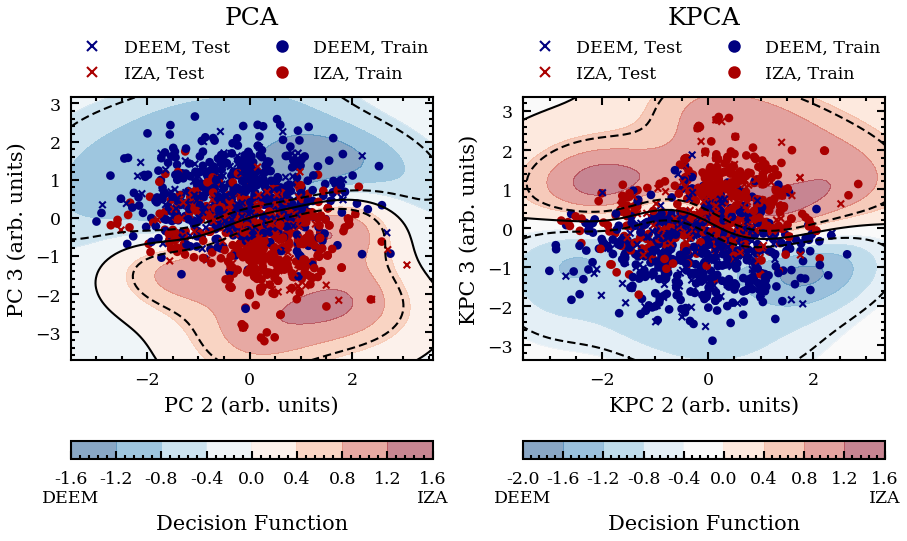

In [178]:
fig = plt.figure(figsize=(7.0, 3.5))
axs_PCA = fig.add_subplot(1, 2, 1)
axs_KPCA = fig.add_subplot(1, 2, 2)

colors_train_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_PCA]
colors_test_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_PCA]

colors_train_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_KPCA]
colors_test_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_KPCA]

PCA_min_x = np.amin(np.concatenate((PCA_train, PCA_test))[:, 0+1])
PCA_min_y = np.amin(np.concatenate((PCA_train, PCA_test))[:, 1+1])
PCA_max_x = np.amax(np.concatenate((PCA_train, PCA_test))[:, 0+1])
PCA_max_y = np.amax(np.concatenate((PCA_train, PCA_test))[:, 1+1])

PCA_xx, PCA_yy = np.meshgrid(np.linspace(PCA_min_x-0.5, PCA_max_x+0.5, 100),
                             np.linspace(PCA_min_y-0.5, PCA_max_y+0.5, 100))

df_PCA = svc_PCA.decision_function(np.column_stack((PCA_xx.ravel(), PCA_yy.ravel())))
df_PCA = np.reshape(df_PCA, PCA_xx.shape)

KPCA_min_x = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 0+1])
KPCA_min_y = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 1+1])
KPCA_max_x = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 0+1])
KPCA_max_y = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 1+1])

KPCA_xx, KPCA_yy = np.meshgrid(np.linspace(KPCA_min_x-0.5, KPCA_max_x+0.5, 100),
                               np.linspace(KPCA_min_y-0.5, KPCA_max_y+0.5, 100))

df_KPCA = svc_KPCA.decision_function(np.column_stack((KPCA_xx.ravel(), KPCA_yy.ravel())))
df_KPCA = np.reshape(df_KPCA, KPCA_xx.shape)

contour_PCA = axs_PCA.contourf(PCA_xx, PCA_yy, df_PCA, cmap='RdBu_r', alpha=0.5)
axs_PCA.contour(PCA_xx, PCA_yy, df_PCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_PCA.scatter(PCA_train[:, 0+1], PCA_train[:, 1+1], marker='o', c=colors_train_PCA[:], s=10)
axs_PCA.scatter(PCA_test[:, 0+1], PCA_test[:, 1+1], marker='x', c=colors_test_PCA[:], s=10)

contour_KPCA = axs_KPCA.contourf(KPCA_xx, KPCA_yy, df_KPCA, cmap='RdBu_r', alpha=0.5)
axs_KPCA.contour(KPCA_xx, KPCA_yy, df_KPCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_KPCA.scatter(KPCA_train[:, 0+1], KPCA_train[:, 1+1], marker='o', c=colors_train_KPCA[:], s=10)
axs_KPCA.scatter(KPCA_test[:, 0+1], KPCA_test[:, 1+1], marker='x', c=colors_test_KPCA[:], s=10)

axs_PCA.set_xlabel('PC 2 (arb. units)')
axs_PCA.set_ylabel('PC 3 (arb. units)')

axs_KPCA.set_xlabel('KPC 2 (arb. units)')
axs_KPCA.set_ylabel('KPC 3 (arb. units)')

xblue = mpllines.Line2D([], [], color=colorList[2], marker='x', 
                        markersize=5, linestyle='None', label='DEEM, Test')
oblue = mpllines.Line2D([], [], color=colorList[2], marker='o', 
                        markersize=5, linestyle='None', label='DEEM, Train')
xred = mpllines.Line2D([], [], color=colorList[1], marker='x',
                      markersize=5, linestyle='None', label='IZA, Test')
ored = mpllines.Line2D([], [], color=colorList[1], marker='o',
                      markersize=5, linestyle='None', label='IZA, Train')

axs_PCA.legend(handles=(xblue, xred, oblue, ored), loc='lower center', 
               bbox_to_anchor=(0.5, 1.0), ncol=2)
axs_KPCA.legend(handles=(xblue, xred, oblue, ored), loc='lower center', 
               bbox_to_anchor=(0.5, 1.0), ncol=2)

axs_PCA.set_title('PCA', pad=35)
axs_KPCA.set_title('KPCA', pad=35)

cb_PCA = fig.colorbar(contour_PCA, ax=axs_PCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')
cb_KPCA = fig.colorbar(contour_KPCA, ax=axs_KPCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')

cb_PCA_ticks = ['%.1f' % i for i in cb_PCA.get_ticks()]
cb_PCA_ticks[0] = cb_PCA_ticks[0] + '\nDEEM'
cb_PCA_ticks[-1] = cb_PCA_ticks[-1] + '\nIZA'
cb_PCA.set_ticklabels(cb_PCA_ticks)

cb_KPCA_ticks = ['%.1f' % i for i in cb_KPCA.get_ticks()]
cb_KPCA_ticks[0] = cb_KPCA_ticks[0] + '\nDEEM'
cb_KPCA_ticks[-1] = cb_KPCA_ticks[-1] + '\nIZA'
cb_KPCA.set_ticklabels(cb_KPCA_ticks)

fig.subplots_adjust(wspace=0.25)

fig.savefig('../Results/DEEM_1k/svm_IZAonDEEM_6.0.png', bbox_inches='tight')

plt.show()